# Homework 3

Your name:Sam Duran

Your Andrew ID:sduran

Collaborators (if none, say \"none\"; do *not* leave this blank):none

# Part 1: Email spam classification [45 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

### (a) Print the number of ham and spam emails [1 point]
 
In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [134]:
import os

def email_count(directory):
    doc_list = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            doc_list.append(filename)
    return len(doc_list)

dir_list = [x[0] for x in os.walk('./email-data')][1:]   

for i in dir_list:
    print("count of emails in: " + i)
    print(email_count(i))

count of emails in: ./email-data\ham
1500
count of emails in: ./email-data\spam
3671
count of emails in: ./email-data\testing
100


In [ ]:
# The data is imbalanced as there are more spam emails than ham emails. This can cause problems in classification problems 
# as many ML algorithms might just view the minority class as noise and mostly predict the majority class. I can resolve this
# by oversampling the minority class and ensuring that the data is more balanced when training.   
# Also, I might see what seems like a high accuracy number, but that simply reflects the distribution of the data
# one way to combat this is ensure that I am always comparing my results to a baseline that reflects the 
# distribution of the data

### (b) Construct the documents [4 points]
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [135]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [136]:
data = []
labels = []
for (root,dirs,files) in os.walk('./email-data'):
    for file in files:
        if root == './email-data\ham':
            data.append([makeWordList(os.path.join(root,file))])
            labels.append(1)
        if root == './email-data\spam':
            data.append([makeWordList(os.path.join(root,file))])
            labels.append(0)

final = []
for i in data:
    final.append(i[0])

### (c) Construct the document matrix `X` as a matrix of word frequencies [5 points]

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [137]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(max_df=0.8,
                                min_df=50,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(final)

print('size of vocab')
tf.shape[1]

size of vocab


1680

### (d) k-NN and random forest: Hyperparameter selection [15 points]

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - Random forest: Select `max_features` **and** `min_samples_leaf` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_C`, `best_max_features`, and `best_min_samples_leaf` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [138]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

num_folds = 5
k_fold = KFold(num_folds,shuffle=True)
hyperparameter_settings = [2,3,4,5,6,7,8]  # fill this with hyperparameter settings that you want to try

best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    for proper_train_indices, val_indices in k_fold.split(tf):
        proper_train_features = tf[proper_train_indices]
        proper_train_labels = np.array(labels)[proper_train_indices]
        val_features = tf[val_indices]
        val_labels = np.array(labels)[val_indices]
        
        knn = KNeighborsClassifier(n_neighbors=hyperparam_setting)
        knn.fit(proper_train_features,proper_train_labels)
        pred = knn.predict(val_features)
        score = f1_score(pred, val_labels)
        fold_scores.append(score)
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

best_k = best_hyperparam_setting

print('Best hyperparameter setting (k-fold):', best_hyperparam_setting)

num_features = tf.shape[1]

hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(num_features) / 4)),
                                                int(np.ceil(np.sqrt(num_features))),
                                                int(np.ceil(np.sqrt(num_features) * 4))]
                           for min_samples_leaf in [1, 2, 4, 8, 16]]  


for hyperparameter_setting in hyperparameter_settings:
    max_features, min_samples_leaf = hyperparameter_setting
    fold_scores = []
    for proper_train_indices, val_indices in k_fold.split(tf):
        proper_train_features = tf[proper_train_indices]
        proper_train_labels = np.array(labels)[proper_train_indices]
        val_features = tf[val_indices]
        val_labels = np.array(labels)[val_indices]
        
        classifier = RandomForestClassifier(max_features=max_features,
                                            min_samples_leaf=min_samples_leaf)
        
        classifier.fit(proper_train_features, proper_train_labels)
        pred = classifier.predict(val_features)
        score = f1_score(pred, val_labels)
        fold_scores.append(score)
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = (max_features, min_samples_leaf)
        
best_max_features = best_hyperparam_setting[0]
best_min_samples_leaf = best_hyperparam_setting[1]
        
print('Best hyperparameter setting (random forest):', best_hyperparam_setting)

Best hyperparameter setting (k-fold): 3
Best hyperparameter setting (random forest): (41, 1)


### (e) Classifier testing: Precision-Recall and ROC curves [20 points]

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the training data.
   - Use test emails to in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 2 ROC curves, one for each classifier.
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 2 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

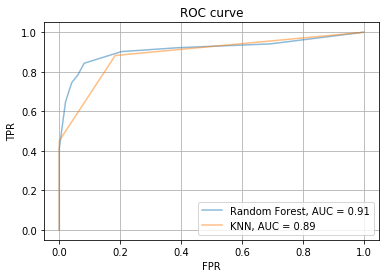

In [178]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

data = []
labels = []
test_mask = []
train_mask = []
for (root,dirs,files) in os.walk('./email-data'):
    for file in files:
        train_mask.append(root in ['./email-data\spam','./email-data\ham'])
        test_mask.append(root not in ['./email-data\spam','./email-data\ham'])
        if file[-8:] == 'spam.txt':
            data.append([makeWordList(os.path.join(root,file))])
            labels.append(0)
        else:
            data.append([makeWordList(os.path.join(root,file))])
            labels.append(1)

final = []
for i in data:
    final.append(i[0])

tf_vectorizer = CountVectorizer(max_df=0.8,
                                min_df=50,
                                stop_words='english')

tf = tf_vectorizer_test.fit_transform(final)
tf = tf.todense()

tf_train = tf[train_mask]
tf_test = tf[test_mask]

label_train = np.array(labels)[train_mask]
label_test = np.array(labels)[test_mask]

classifier = RandomForestClassifier(max_features=41,min_samples_leaf=1)
classifier.fit(tf_train, label_train)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(tf_train,label_train)


y_score = classifier.predict_proba(tf_test)[:,1]
fpr, tpr, thresholds = roc_curve(label_test, y_score, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, linestyle='-', alpha=0.5, label = 'Random Forest, AUC = ' + str(np.round(auc,2)))

y_score = knn.predict_proba(tf_test)[:,1]
fpr, tpr, thresholds = roc_curve(label_test, y_score, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, linestyle='-', alpha=0.5, label = 'KNN, AUC = ' + str(np.round(auc,2)))


plt.title("ROC curve")
plt.legend(loc = "best")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.show() 


To deal with mismatch in number of features. I created a new tf_vectorizor object with both train and test data, then used a mask to split train and test data up.   

Random Forest seems to dominate KNN on ROC curve, would choose this approach over KNN

# Part 2: Questionnaire [5 points]

Please answer this questionnaire: https://forms.gle/2DEGoF5vRSo8hfQ96